In [1]:
import h5py
import matplotlib.pyplot as plt
import mpl_lego as mplego
import neuropacks as packs
import numpy as np
import os
import pickle

from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from mpl_lego.ellipse import plot_cov_ellipse
from noise_correlations import analysis, utils 
from scipy.stats import spearmanr, ttest_1samp, binned_statistic
from settings import (colors, titles, ax_label_size, tick_label_size,
                      letter_size, legend_size, lw, line_alpha, fill_alpha,
                      title_pad, ci)

In [2]:
ccycle = mplego.colors.get_default_ccycle()

In [3]:
exp = 10
base_path = f"/storage/noise_correlations/exp{exp}"

In [4]:
ret2_path = os.path.join(base_path, f'exp{exp}_ret2_20_1000_1000.h5')
pvc11_1_path = os.path.join(base_path, f'exp{exp}_1_pvc11_20_1000_1000.h5')
ecog_path = os.path.join(base_path, f'exp{exp}_ecog_20_3000_1000.h5')

In [5]:
ret2 = h5py.File(ret2_path, 'r')
pvc11_1 = h5py.File(pvc11_1_path, 'r')
ecog = h5py.File(ecog_path, 'r')
results = [ret2, pvc11_1, ecog]

In [6]:
n_max_units = pvc11_1['units'].shape[2]
dims = 3 + np.arange(n_max_units - 2)
n_results = len(results)

In [7]:
keep = [0, 1, 4]
with open(os.path.join(base_path, f'exp{exp}_ffs.pkl'), 'rb') as f:
    opt_fa_ffs, obs_ffs = pickle.load(f)
opt_fa_ffs = [opt_fa_ffs[ii] for ii in keep]
obs_ffs = [obs_ffs[ii] for ii in keep]
    
with open(os.path.join(base_path, f'exp{exp}_cdfs.pkl'), 'rb') as f:
    all_opt_fa_cdfs, all_obs_equiv_cdfs = pickle.load(f)
all_opt_fa_cdfs = [all_opt_fa_cdfs[ii] for ii in keep]
all_obs_equiv_cdfs = [all_obs_equiv_cdfs[ii] for ii in keep]

In [8]:
# Calculate correlations between max CDFs and percentiles
fa_ff_corrs = np.zeros((len(results), dims.size, 3))
fa_nd_corrs = np.zeros((len(results), dims.size, 3))

def rho(x, y):
    return spearmanr(x, y).correlation

for result_idx, result in enumerate(results):
    for dim_idx, dim in enumerate(dims):
        x = abs(np.log(opt_fa_ffs[result_idx][dim_idx]) - np.log(obs_ffs[result_idx][dim_idx]))
        y = result['p_fa_lfi'][dim_idx]
        fa_ff_corrs[result_idx, dim_idx] = utils.run_bootstrap((x, y), rho, ci)
        x = abs(np.max(all_opt_fa_cdfs[result_idx][dim], axis=-1) - np.max(all_obs_equiv_cdfs[result_idx][dim], axis=-1))
        fa_nd_corrs[result_idx, dim_idx] = utils.run_bootstrap((x, y), rho, ci)

dim_idx = 0
dim = dim_idx + 3
# Maximum values
max_null_cdfs = [np.max(all_obs_equiv_cdfs[result_idx][dim], axis=-1)
                 for result_idx in range(n_results)]
max_opt_fa_cdfs = [np.max(all_opt_fa_cdfs[result_idx][dim], axis=-1)
                   for result_idx in range(n_results)]

clim:  (1.0, 436.0)
binned med ff:  [0.512  0.4115 0.2725 0.2255 0.148  0.148  0.168  0.122  0.077  0.106
 0.1165 0.1205 0.089  0.079  0.044  0.0685 0.028  0.0535 0.071  0.083
 0.0485 0.019  0.056  0.039 ]
clim:  (1.0, 436.0)
binned med nd:  [0.469  0.1915 0.141  0.112  0.089  0.0615 0.045  0.0675 0.0975 0.053
 0.042  0.0365 0.029  0.032  0.02   0.016  0.033  0.015  0.021  0.0205
 0.0125 0.173  0.0465    nan]
p ff:  Ttest_1sampResult(statistic=array([-95.77135958, -88.61964939, -81.08709971]), pvalue=array([1.12633201e-24, 4.20315907e-24, 1.89643484e-23]))
p nd:  Ttest_1sampResult(statistic=array([-35.73507108, -32.99781446, -30.38703376]), pvalue=array([1.95113959e-17, 7.42538791e-17, 2.94878649e-16]))

clim:  (1.0, 436.0)
binned med ff:  [0.416  0.135  0.0645 0.046  0.0305 0.019  0.018  0.012  0.008  0.01
 0.006  0.0035 0.006  0.005  0.004  0.002  0.003  0.1185 0.002  0.
    nan    nan    nan 0.    ]
clim:  (1.0, 436.0)
binned med nd:  [0.604  0.443  0.3195 0.271  0.198  0.1485 0.124

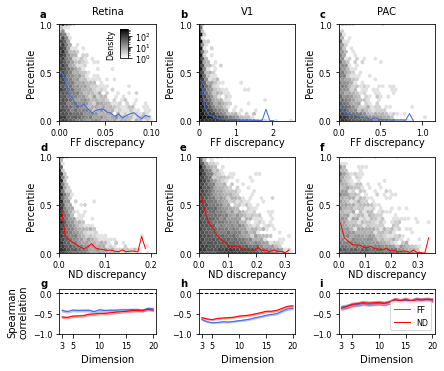

In [51]:
"""
Figure Settings
"""
# Histogram settings
hist_lw = 1

# Hexbin settings
gridsize = 25
hex_lw = .02

model_labels = ['Observed', 'FA']
label_dict = {'observed': model_labels[0], 'fa': model_labels[1]}
bins = [
    np.linspace(-1.5, -0.75, 30),
    np.linspace(0, 1.2, 30),
    np.linspace(0, 1.5, 30)
]

"""
Figure 6
"""
figsize = (6, 5.)
fig = plt.figure(figsize=figsize)
le = .12
re = .01
te = .05
be = .09
hg = .1
vg = .1
w = (1. - le - re - 2.*hg) / 3.
h = w * figsize[0] / figsize[1]
sh = (1. - te - be - 2*h - 2*vg)

axes = np.empty((3, 3), dtype=object)
axes[0] = [fig.add_axes([le + ii*(w + hg), be + sh + 2*vg + h, w, h]) for ii in range(3)]
axes[1] = [fig.add_axes([le + ii*(w + hg), be + sh + vg, w, h]) for ii in range(3)]
axes[2] = [fig.add_axes([le + ii*(w + hg), be, w, sh]) for ii in range(3)]

cw, ch = .02, .08
dw, dh = .625*w, .65*h
caxes = fig.add_axes([le + dw, be + sh + 2*vg + h + dh, cw, ch])
# caxes[:] = [fig.add_axes([le + ii*(w + hg) + .7*w, be + rh + vg+.03, .01, h/3.5])
#             for ii in range(3)]

norms = [
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1),
    Normalize(vmin=0, vmax=1.0)
]
extents_ff = [
    (0, 0.1, 0, 1),
    (0, 2.5, 0, 1),
    (0, 1.1, 0, 1)
]
extents_nd = [
    (0, 0.2, 0, 1),
    (0, .32, 0, 1),
    (0, .35, 0, 1)
]


for idx, result in enumerate(results):
    # Calculate relevant quantities
    log_obs_ffs = np.log10(obs_ffs[idx][dim_idx])
    log_opt_fa_ffs = np.log10(opt_fa_ffs[idx][dim_idx])
    # Hexbin comparing FFs to FA null model
    percentiles = result['p_fa_lfi'][dim_idx]
    x = abs(log_opt_fa_ffs - log_obs_ffs)
    im = axes[0, idx].hexbin(
        x,
        percentiles,
        gridsize=gridsize,
        cmap='gray_r',
        extent=extents_ff[idx],
        linewidths=hex_lw,
        bins='log',
        vmin=1,
        vmax=436)
    print('clim: ', im.get_clim())
    if idx == 0:
        fig.colorbar(im, cax=caxes)
    bins = np.linspace(extents_ff[idx][0], extents_ff[idx][1], gridsize)
    stat, _, _ = binned_statistic(x, percentiles, statistic='median', bins=bins)
    print('binned med ff: ', stat)
    axes[0, idx].plot(bins[:-1] + np.diff(bins) / 2., stat, c='royalblue', lw=1)
    
        # Calculate relevant quantities
    x =  abs(max_opt_fa_cdfs[idx] - max_null_cdfs[idx])
    #x =  max_opt_fa_cdfs[idx]
    #x =  max_null_cdfs[idx]
    im = axes[1, idx].hexbin(
        x,
        percentiles,
        gridsize=gridsize,
        cmap='gray_r',
        extent=extents_nd[idx],
        linewidths=hex_lw,
        bins='log',
        vmin=1,
        vmax=436)
    print('clim: ', im.get_clim())
    bins = np.linspace(extents_nd[idx][0], extents_nd[idx][1], gridsize)
    stat, _, _ = binned_statistic(x, percentiles, statistic='median', bins=bins)
    print('binned med nd: ', stat)
    axes[1, idx].plot(bins[:-1] + np.diff(bins) / 2., stat, c='red', lw=1)
    
    # Bottom row
    axes[2, idx].plot(
        dims,
        fa_ff_corrs[idx, :, 1],
        color='royalblue',
        lw=lw,
        markersize=2, label='FF')
    axes[2, idx].fill_between(
        dims,
        fa_ff_corrs[idx, :, 0],
        fa_ff_corrs[idx, :, 2],
        alpha=fill_alpha,
        color='royalblue')
    axes[2, idx].plot(
        dims,
        fa_nd_corrs[idx, :, 1],
        color='r',
        lw=lw,
        markersize=2, label='ND')
    axes[2, idx].fill_between(
        dims,
        fa_nd_corrs[idx, :, 0],
        fa_nd_corrs[idx, :, 2],
        alpha=fill_alpha,
        color='r')
    print('p ff: ', ttest_1samp(fa_ff_corrs[idx], 0.))
    print('p nd: ', ttest_1samp(fa_nd_corrs[idx], 0.))
    print()


for ax in axes[:2].ravel():
    ax.set_ylim(0, 1)
    ax.set_yticks([0, .5, 1])
    ax.set_ylabel('Percentile', fontsize=ax_label_size)
    ax.set_xlim(0, None)

# Top row settings
for ax in axes[0]:
    ax.set_xlabel(r'FF discrepancy', fontsize=ax_label_size, labelpad=0)

# Top row settings
for ax in axes[1]:
    ax.set_xlabel(r'ND discrepancy', fontsize=ax_label_size, labelpad=0)

# Apply titles
axes[0, 0].set_title(r'Retina', fontsize=ax_label_size, pad=title_pad)
axes[0, 1].set_title(r'V1', fontsize=ax_label_size, pad=title_pad)
axes[0, 2].set_title(r'PAC', fontsize=ax_label_size, pad=title_pad)

for ax in axes[2]:
    ax.set_xlim([2.5, 20.5])
    ax.set_ylim([-1, 0.1])
    ax.set_xticks([3, 5, 10, 15, 20])
    ax.set_yticks([-1, -0.5, 0])
    ax.axhline(0, color='k', linestyle='--', lw=lw)
    ax.set_xlabel('Dimension', fontsize=ax_label_size)
axes[2, 0].set_ylabel('Spearman\ncorrelation', fontsize=ax_label_size)
axes[2, 2].legend(loc='lower right', fontsize=legend_size)

# Apply subplot labels
lets = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n']
c = 0
for ii in range(3):
    for jj in range(3):
        ax = axes[ii, jj]
        ax.text(-.2, 1.07, lets[c], size=letter_size, fontweight='bold',
                transform=ax.transAxes)
        c += 1
for ax in axes.ravel():
    ax.tick_params(labelsize=tick_label_size)
caxes.tick_params(labelsize=tick_label_size)
caxes.set_ylabel('Density', size=tick_label_size)
caxes.yaxis.set_label_position('left')

plt.savefig('figure4.pdf', dpi=300)
plt.savefig('figure4.jpg', dpi=300)
plt.show()